In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

In [2]:
config = {
    'project': 'babble',
    'domain': 'cdr',
    'db_name': 'babble_cdr_labeled',
    'splits': [0,1],
    'gold_explanations': True,
    'supervision': 'metal',
    'gen_model_search_space': 1,
    'gen_f_beta': 1.0,
#     'gen_init_params': {
#         'class_prior'           : True,
#         'lf_prior'              : False, 
#         'lf_propensity'         : True,
#         'lf_class_propensity'   : False,
#         'seed'                  : None,
#     },
#     'gen_params_range': {
#         'step_size'     : [0.01, 0.05, 0.1, 0.25],
#         'reg_param'     : [0.0, 0.1, 0.25, 0.5, 1.0],
#     },
#     'gen_params_default': {
#         'step_size'     : 0.01,
#         'reg_param'     : 0.25, 
#         'epochs'         : 0,
#     },
    'tune_b': True,
    'disc_model_class': 'logreg',
    'disc_model_search_space': 1,
#     'disc_params_default': {
#         'lr': 0.001,
#         'l2_penalty': 0.001,
#         'rebalance': 0,
#         'batch_size': 32
#     }
}
# init_class_prior: ? spouse, ? cdr, -1.39 protein

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = 'babble_' + config['domain'] + ('_debug' if config.get('debug', False) else '')
DB_NAME = config.get('db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///babble_cdr_labeled.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.pipelines import merge_configs, get_local_pipeline
config = merge_configs(config)

from snorkel.models import candidate_subclass
candidate_class = candidate_subclass(config['candidate_name'], config['candidate_entities'])

pipeline = get_local_pipeline(config['domain'])
pipe = pipeline(session, candidate_class, config)

Overwriting disc_model_search_space=10 to disc_model_search_space=1
Overwriting tune_b=False to tune_b=True
Overwriting domain=None to domain=cdr
Overwriting print_freq=1 to print_freq=5
Overwriting l2_penalty=1.0 to l2_penalty=10
Overwriting rebalance=0.25 to rebalance=0
Overwriting l1_penalty=1.0 to l1_penalty=0
Overwriting n_epochs=25 to n_epochs=20
Overwriting epochs=500 to epochs=0
Overwriting reg_param=0.25 to reg_param=0.5
Overwriting gold_explanations=False to gold_explanations=True
Overwriting babbler_candidate_split=1 to babbler_candidate_split=[0, 1, 2]
Overwriting disc_model_class=lstm to disc_model_class=logreg
Overwriting supervision=generative to supervision=metal
Overwriting seed=None to seed=123
Using CdrPipeline object.


In [5]:
# %time pipe.parse()

In [6]:
# %time pipe.extract()

In [7]:
# for split in [0,1,2]:
#     print(session.query(pipe.candidate_class).filter(
#         pipe.candidate_class.split == split).count())

In [8]:
# %time pipe.load_gold()

In [9]:
# %time pipe.featurize()

In [10]:
# %time pipe.collect()

In [11]:
# %time pipe.label()

Using L_train: <6667x28 sparse matrix of type '<type 'numpy.int64'>'
	with 24177 stored elements in Compressed Sparse Row format>
Using L_gold_train: <6667x1 sparse matrix of type '<type 'numpy.int64'>'
	with 6667 stored elements in Compressed Sparse Row format>
Positive Fraction: 20.9%

Using L_dev: <773x28 sparse matrix of type '<type 'numpy.int64'>'
	with 2863 stored elements in Compressed Sparse Row format>
Using L_gold_dev: <773x1 sparse matrix of type '<type 'numpy.int64'>'
	with 773 stored elements in Compressed Sparse Row format>
Positive Fraction: 20.6%

Using L_test: <4101x28 sparse matrix of type '<type 'numpy.int64'>'
	with 14555 stored elements in Compressed Sparse Row format>
Using L_gold_test: <4101x1 sparse matrix of type '<type 'numpy.int64'>'
	with 4101 stored elements in Compressed Sparse Row format>
Positive Fraction: 22.8%

Grid search over {'step_size': [0.01], 'l2': [0.5]}:
>>> Training for {'step_size': 0.01, 'l2': 0.5}:
Training completed.
Saving model @ score 

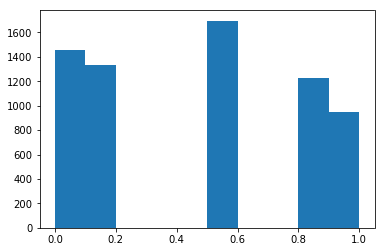

CPU times: user 5.84 s, sys: 96.4 ms, total: 5.94 s
Wall time: 5.94 s


In [12]:
%time pipe.supervise()

(6667,)


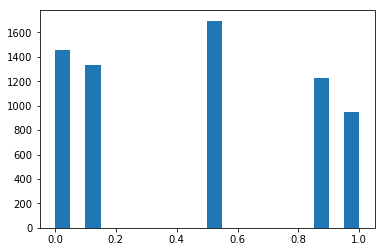

### [7.1] Begin training discriminative model
Skipping grid search.
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=4971  #epochs=20  batch size=32
[SparseLogi...] Epoch 0 (0.56s) 	Train Loss=8135.245	Dev F1=41.65
[SparseLogi...] Epoch 5 (3.33s) 	Train Loss=14207.895	Dev F1=42.45
[SparseLogi...] Epoch 10 (6.16s) 	Train Loss=17857.035	Dev F1=41.41
[SparseLogi...] Epoch 15 (8.98s) 	Train Loss=19897.449	Dev F1=42.72
[SparseLogi...] Epoch 19 (11.25s) 	Train Loss=21738.121	Dev F1=40.19
[SparseLogisticRegression] Model saved as <SparseLogisticRegression>
[SparseLogisticRegression] Training done (11.61s)
[SparseLogisticRegression] Loaded model <SparseLogisticRegression>
[SparseLogisticRegression] Model saved as <discriminative_cdr>
### Done in 12.4s.

Disc on dev set (opt_b=0.25): P=0.289 | R=0.667 | F1=0.403
### [7.3] Evaluate discriminative model (opt_b=0.25)
Disc on test set (opt_b=0.25): P=0.314 | R=0.685 | F1=0.431
### Done in 0.1s.

Final performance on TEST

In [13]:
%time pipe.classify()

In [14]:
w, b = pipe.disc_model.get_weights()
top_w = sorted(zip(w, range(len(w))), reverse=True)

In [15]:
from snorkel.annotations import load_feature_matrix

X_train = load_feature_matrix(pipe.session, split=pipe.config['traditional_split'])

In [18]:
for (w, idx) in top_w[-100:]:
    f = X_train.get_key(pipe.session, idx)
    print(w, f)

(-0.83226359, FeatureKey (TDL_LEMMA:BETWEEN-MENTION-and-MENTION[resistant]))
(-0.83284986, FeatureKey (TDL_INV_DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[prep|of dobj|protection prep|against]))
(-0.83358681, FeatureKey (TDL_INV_LEMMA:SEQ-BETWEEN[after sodium]))
(-0.83690602, FeatureKey (TDL_LEMMA:BETWEEN-MENTION-and-MENTION[rat]))
(-0.83780932, FeatureKey (TDL_INV_DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[ROOT|take]))
(-0.83899432, FeatureKey (TDL_DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[pobj|atropine acl|prevent dobj|occurrence]))
(-0.83921063, FeatureKey (TDL_LEMMA:BETWEEN-MENTION-and-MENTION[of prevent arrhythmia]))
(-0.84075052, FeatureKey (TDL_LEMMA:BETWEEN-MENTION-and-MENTION[atropine prevent occurrence]))
(-0.84186089, FeatureKey (TDL_LEMMA:BETWEEN-MENTION-and-MENTION[sign induce]))
(-0.84317958, FeatureKey (TDL_LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[association between]))
(-0.84549659, FeatureKey (TDL_INV_DEP_LABEL:BETWEEN-MENTION-and-MENTION[prep conj nmod]))
(-0.8

In [17]:
#       F1 Score  Precision    Recall
# Disc  0.461176   0.368421  0.616352
# Gen   0.454918   0.337386  0.698113